# First Order Ego Graph Analysis on Facebook User 2

In this notebook we analyze the first order egograph of a Facebook account with $\sim10^3$ friends.

## Modules

In [1]:
# Enable interactive numpy and matplotlib
%pylab inline

# Data Wrangling 
import pandas as pd
import numpy as np

# Data Analysis
import powerlaw as pwl

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

# Network Analysis 
import networkx as nx
from networkx.algorithms import community
import networkx.algorithms.centrality as nc
import social_physics as soc

# Network Epidemiology 
import EoN

# Data Visualization
import seaborn as sns
from netwulf import visualize

# Other Utilities 
import sys, os, os.path
import itertools
from progressbar import ProgressBar, Bar, Percentage
from operator import itemgetter
from collections import Counter
from collections import defaultdict
import random

# Reload Custom Modules
from importlib import reload
soc = reload(soc)

Populating the interactive namespace from numpy and matplotlib


## Graph Data Collection

Import the (undirected) graph.

In [2]:
# Import graphml file 
G = nx.Graph(nx.read_graphml("/Users/pietromonticone/github/SocialPhysicsProject/Data/GraphML/Facebook2.graphml"))

# Rename the graph 
G.name = "Facebook Friend Ego Graph"

# Show the basic attributes of the graph
print(nx.info(G))

# Relable the nodes (from strings of Twitter IDs to integers)
G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

Name: Facebook Friend Ego Graph
Type: Graph
Number of nodes: 990
Number of edges: 13830
Average degree:  27.9394


## Graph Visualization 

```python 
visualize(G)
```

![](./Images/Facebook/Facebook2.png)

## Graph Data Analysis 

Let's visulize normalized degree distribution.

### Degree Distribution 

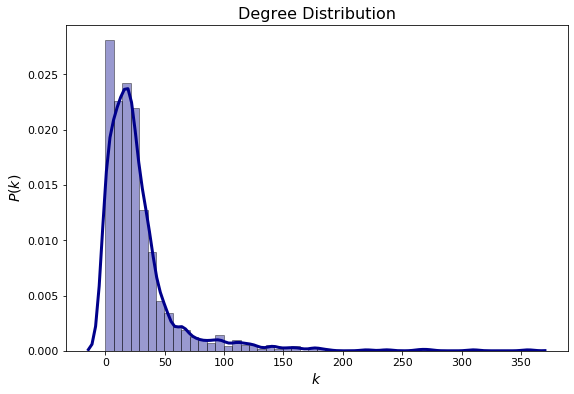

Mean =  27.939393939393938 
Var =  1154.9700642791554


In [3]:
# Get degree distribution 
undirected_degree_distribution, degree_mean, degree_variance = soc.get_degree_distribution(G, "degree")

# Set figure size
plt.figure(figsize=(9,6))

# Plot undirected degree distribution 
soc.plot_degree_distribution(undirected_degree_distribution, 
                             title = "Degree Distribution", 
                             log = False, 
                             display_stats = True)

# Show mean and variance of the undirected degree distribution 
print("Mean = ", degree_mean,"\nVar = ", degree_variance)

### Logarithmic Binning
The black line is the empirical linearly binned pdf. 

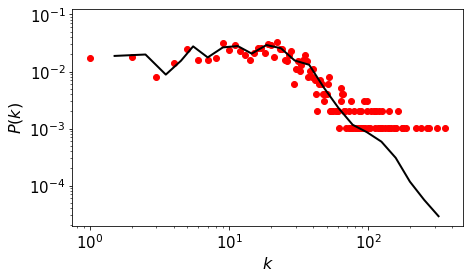

In [4]:
# Set figure size
plt.figure(figsize=(7,4))

# Plot
pwl_distribution = soc.power_law_plot(graph = G, log = True,linear_binning = False, bins = 1000, draw = True)

The empirical PDF doesn't interpolate because it is obtained via linear binning while the red data points represent the logarithmic binning.

### Linear Binning

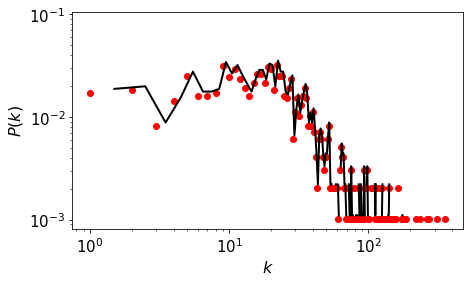

In [5]:
# Set figure size
plt.figure(figsize=(7,4))

# Plot 
pwl_distribution = soc.power_law_plot(graph = G, log = True,linear_binning = True, bins = 90, draw = True)

The figure above interpolates because it uses linear binnig both for scatter plot and pdf binning. 

### Power Law Fitting 

Here we estimate the measure to which the network follows a power law, and compare it with other common distributions.

#### Parameters Estimation

In [6]:
fit_function = pwl.Fit(list(undirected_degree_distribution.values())) 


print("Exponent = ", fit_function.power_law.alpha)
print("Sigma (error associated to exponent) = ",fit_function.power_law.sigma)
xmin = fit_function.power_law.xmin
print("x_min = ",xmin)
print("Kolmogorov-Smirnov distance = ",fit_function.power_law.D)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Exponent =  2.8238690285658734
Sigma (error associated to exponent) =  0.10512606312129011
x_min =  30.0
Kolmogorov-Smirnov distance =  0.04391267066324123


Because the fitted $x_{min} = 30$, let's require it to be a little higher prior to fitting

In [7]:
fit_function_fix_xmin = pwl.Fit(list(undirected_degree_distribution.values()),xmin= 5) 
print("Exponent = ", fit_function_fix_xmin.power_law.alpha)
print("Sigma (error associated to exponent) = ",fit_function_fix_xmin.power_law.sigma)
print("x_min = ",fit_function_fix_xmin.power_law.xmin)
print("Kolmogorov-Smirnov distance = ",fit_function_fix_xmin.power_law.D)

Exponent =  1.6487270726543413
Sigma (error associated to exponent) =  0.022264255495866973
x_min =  5.0
Kolmogorov-Smirnov distance =  0.2552642618263717


Values less than or equal to 0 in data. Throwing out 0 or negative values


Now the error (sigma) is way lower than before, but Kolmogorov-Smironv is higher as expected (because we fixed $x_{min}$ prior to fitting). Thus we confirmed that a power law fitting is rather good for this network. It is to be recalled that power laws are usually able to explain most of the variance though.<br>
Let us now compare the actual pdf with the fitted power law near the tail.<br>
<span style="color:blue">BLUE</span> : Fitted power law <br>
<span style="color:black">BLACK</span> : plotted pdf

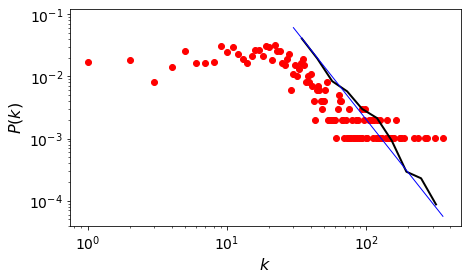

In [8]:
# Set figure size
plt.figure(figsize=(7,4))

pwl_distribution = soc.power_law_plot(graph = G, log = True, linear_binning = False, bins = 90, draw = True, x_min = xmin)

fit_function.power_law.plot_pdf(color='b', linestyle='-', linewidth=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$k$', fontsize=16)
plt.ylabel('$P(k)$', fontsize=16)
plt.show()

Also, let's plot the power law fitted with the $x_{min}$ fixed.

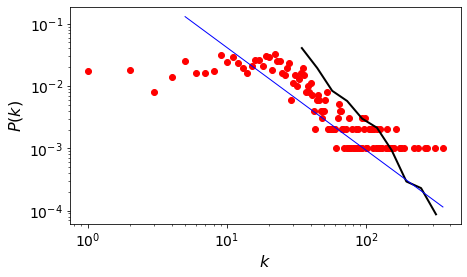

In [9]:
# Set figure size
plt.figure(figsize=(7,4))

#plt.plot(x,y,'ro')

pwl_distribution = soc.power_law_plot(graph = G, log = True,linear_binning = False, bins = 90, draw = True, x_min = xmin)

fit_function_fix_xmin.power_law.plot_pdf(color='b', linestyle='-', linewidth=1)

#fig.legend(fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$k$', fontsize=16)
plt.ylabel('$P(k)$', fontsize=16)
plt.show()

Let us now compare power law against other probability distributions. Remember that $R$ is the log-likelihood ratio between the two candidate distributions which will be positive if the data is more likely in the first distribution, and negative if the data is more likely in the second distribution. The significance value for that direction is $p$ (the smaller the better). 

In [10]:
R,p = fit_function.distribution_compare('power_law', 'exponential', normalized_ratio=True) 
R,p

/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(3.0323987407030724, 0.0024261848221498994)

In [11]:
R,p = fit_function.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True)
R,p

(-0.36031428106761576, 0.7186121208144485)

In [12]:
R,p = fit_function.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
R,p

Assuming nested distributions


(-1.3722159237984355, 0.08305704685694026)

In [13]:
R,p = fit_function.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True)
R,p

(-0.6043915639569482, 0.5455833431019346)

Let us also compare with the truncated power law:

In [14]:
R,p = fit_function_fix_xmin.distribution_compare('power_law', 'exponential', normalized_ratio=True) 
R,p

(-10.983674005778482, 4.579134535237367e-28)

In [15]:
R,p = fit_function_fix_xmin.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True) 
R,p

(-13.386552453411042, 7.246719885419529e-41)

In [16]:
R,p = fit_function_fix_xmin.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True) 
R,p

(-13.724595557692485, 7.233162409784258e-43)

## Centrality Metrics 

Now we turn to plot centralities.

#### Degree

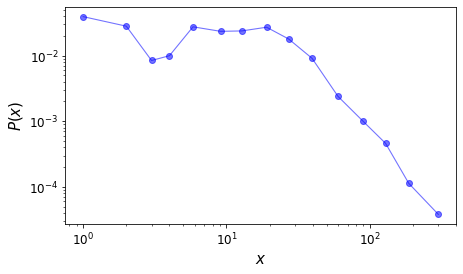

In [17]:
# Get centrality 
degree_centrality = soc.get_centrality(G, "degree")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, degree_centrality, "Blue", 15)

#### Closeness

In connected graphs there is a natural distance metric between all pairs of nodes, defined by the length of their shortest paths. 
The '''farness''' of a node ''x'' is defined as the sum of its distances from all other nodes, and its closeness was defined by Bavelas as the reciprocal of the farness that is:


<center>
$C(x)= \frac{1}{\sum_y d(y,x)}.$
</center>


Thus, the more central a node is the lower its total distance from all other nodes. Note that taking distances ''from'' or ''to'' all other nodes is irrelevant in undirected graphs, whereas in directed graphs distances ''to'' a node are considered a more meaningful measure of centrality, as in general (e.g., in, the web) a node has little control over its incoming links.

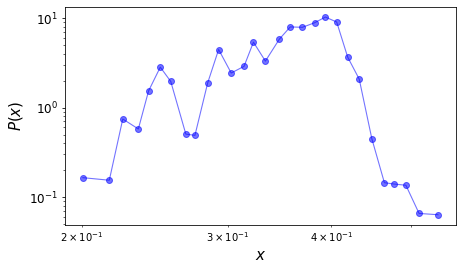

In [18]:
# Get centrality (computationally intensive!)
closeness_centrality = soc.get_centrality(G, "closeness")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, closeness_centrality, "Blue", 30)

#### Bewteenness

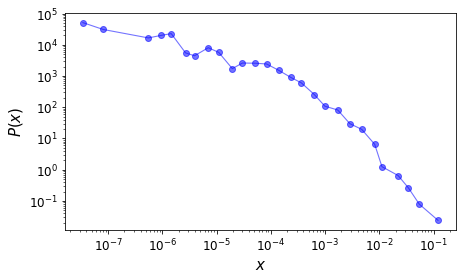

In [19]:
# Get centrality 
betweenness_centrality = soc.get_centrality(G, "betweenness")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, betweenness_centrality, "Blue", 30)

#### Katz

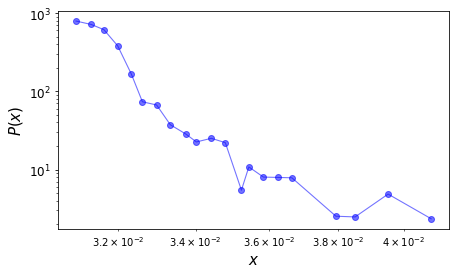

In [20]:
# Get centrality 
katz_centrality = soc.get_centrality(G, "katz")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, katz_centrality, "Blue", 30)

#### Eigenvector 

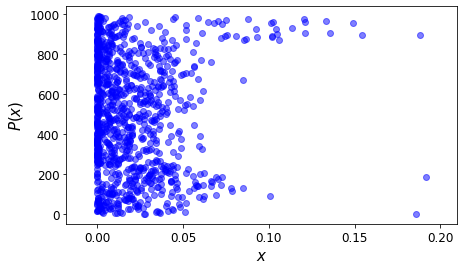

In [21]:
# Get centrality 
eigenvector_centrality = soc.get_centrality(G, "eigenvector")

# Set figure size
plt.figure(figsize=(7,4))

x_centrality=[]
y_centrality=[]
     
for i in eigenvector_centrality:
    x_centrality.append(i[0])
    y_centrality.append(i[1])

plt.scatter(x_centrality,y_centrality, color="Blue", marker="o",alpha=0.50) 
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$x$', fontsize = 15)
plt.ylabel('$P(x)$', fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### PageRank
$$x_i=(1-\alpha) \sum_{j}A^{T}_{ij}\frac{x_j}{k^{out}_j}+\frac{\alpha}{N}$$

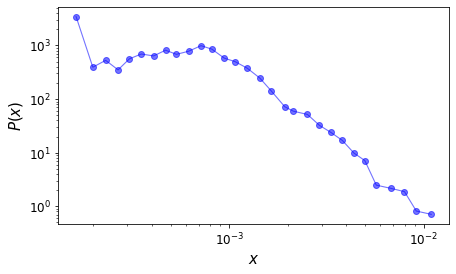

In [22]:
# Get centrality 
pagerank_centrality = soc.get_centrality(G, "pagerank")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, pagerank_centrality, "Blue", 30)

## Connectivity 

In [23]:
# Show the connectivity of the analyzed graph
print("The graph has", G.number_of_nodes(), "nodes and", G.number_of_edges(),"edges.")

print("Is the graph connected?", nx.is_connected(G),".")
G_cc = sorted(list(nx.connected_components(G)),key=len, reverse=True)
print("The graph has", len(G_cc),"connected components.")
print("The sizes of the connected components are", [len(c) for c in sorted(G_cc, key=len, reverse=True)],". \nThus the GCC represents ", len(G_cc[0])/len(G), " of the nodal cardinality.")

The graph has 990 nodes and 13830 edges.
Is the graph connected? False .
The graph has 85 connected components.
The sizes of the connected components are [906, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] . 
Thus the GCC represents  0.9151515151515152  of the nodal cardinality.


## Clustering 

Below the evaluation of the *average clustering coefficient* and the *global clustering coefficient* may be found.

### Global clustering coefficient

The global clustering coefficient measures the number of triangles in the network and it's defined as

$$ C_\Delta = \frac{3 \times \text{triangles}}{\text{triplets}} $$

In order to compare our graph with theorical models (of the same size), it is thus sufficient to evaluate the number of triangles

In [24]:
# Compute the global clustering coefficient of U (the fraction of all possible triangles in the network)
print("Global clustering coefficient = ", nx.transitivity(G))

Global clustering coefficient =  0.17977786296890125


### Average clustering coefficient

The overall level of clustering in a network is measured by Watts and Strogatz as the average of the local clustering coefficients of all the vertices $n$:

$$\bar{C} = \frac{1}{n}\sum_{i=1}^{n} C_i.$$


It is worth noting that this metric places more weight on the low degree nodes, while the transitivity ratio places more weight on the high degree nodes. In fact, a weighted average where each local clustering score is weighted by $k_i(k_i-1)$ is identical to the global clustering coefficient.
<br> As per [this](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html) and [this](https://networkx.github.io/documentation/stable/_modules/networkx/algorithms/cluster.html ) resources we notice that Networkx's `average_clustering` function automatically takes care of the network being directed or not.

In [25]:
G_avg_cc =  nx.average_clustering(G)
print("The average clustering coefficient is ", G_avg_cc)

The average clustering coefficient is  0.33508562973936173


## Path-ology  

### Average shortest path length

In [26]:
GWCC = list(G_cc[0])
print("Since the graph is not connected, but one of its 3 weakly connected compoments amounts for ",len(GWCC)/len(G), "of the nodes count, we approximate its averaege shortest path length with that of its bigger connected component, which is:", nx.average_shortest_path_length(G.subgraph(GWCC)), "\nLet's compare it with lnlnN = ", math.log(math.log(len(GWCC))), "(ultra small world)\nand with lnN/lnlnN = ", math.log(len(GWCC))/math.log(math.log(len(GWCC))), "(equivalent to a power law with exponent 3)\nand with lnN/ln(<k>) = ", math.log((len(GWCC)))/math.log(27.9394), "equivalent to a random network.")

Since the graph is not connected, but one of its 3 weakly connected compoments amounts for  0.9151515151515152 of the nodes count, we approximate its averaege shortest path length with that of its bigger connected component, which is: 2.592826216872172 
Let's compare it with lnlnN =  1.9182510391443206 (ultra small world)
and with lnN/lnlnN =  3.5496080372672734 (equivalent to a power law with exponent 3)
and with lnN/ln(<k>) =  2.0447332893605443 equivalent to a random network.


### Comparisons

#### G vs. ER

The most natural benchmark is a ER (random) network with the same number of nodes and links. In a ER netork, the p_k is poissonian ( an exponential decay) , so let's compare G with random **Erdos-Renyi** graph with the same average connectivity and number of nodes.

In [27]:
nnodes = G.number_of_nodes()
nedges = G.number_of_edges()
#plink = 0.07803
plink = 2*nedges/(nnodes*(nnodes-1)) #2* because it is undirected

ER = nx.fast_gnp_random_graph(nnodes, plink)

average_degree = sum(list(dict(ER.degree()).values()))/len(ER.degree())

# Connectivity
print("The ER graph has", len(ER), "nodes", "and",len(ER.edges()),"edges.\n The difference between its maximum and minimun degree is:",max(list(dict(ER.degree).values()))-min(list(dict(ER.degree).values())),", while the sane difference in our network is:", max(list(dict(G.degree).values()))-min(list(dict(G.degree).values())),"which is higher, confirming that real nertworks are not random.")

# Test connectedness
print("Is the ER graph simply connected ?", nx.is_connected(ER), ". Infact the average degree is:",
      average_degree,"and the natural log of the number of nodes is", 
      math.log(nnodes),"which is smaller, then we are in the connected regime.")

# Average clustering coefficient
print("The average clustering coefficient of ER is", nx.average_clustering(ER),"which, if compared with <k>/N", average_degree/(nnodes), "we can observe they are similar as expected. But it is approximately one order of magnitude less than the egonetwork's one. ")

# Total number of triangles
print("The transitivity of the network is", nx.transitivity(ER))

# Average shortest path
print("The ER graph is small world since the average shortest path is", nx.average_shortest_path_length(ER))

The ER graph has 990 nodes and 13885 edges.
 The difference between its maximum and minimun degree is: 35 , while the sane difference in our network is: 356 which is higher, confirming that real nertworks are not random.
Is the ER graph simply connected ? True . Infact the average degree is: 28.050505050505052 and the natural log of the number of nodes is 6.897704943128636 which is smaller, then we are in the connected regime.
The average clustering coefficient of ER is 0.028597330552068676 which, if compared with <k>/N 0.02833384348535864 we can observe they are similar as expected. But it is approximately one order of magnitude less than the egonetwork's one. 
The transitivity of the network is 0.02842433657290316
The ER graph is small world since the average shortest path is 2.4105238430819824


#### G vs. AB

Thinking about  a broad (not exponential decaying) distribution, more like a power law, we may think about a AB network (albert-barabasi), so let's compare G with random **Albert-Barabasi** graph with the same average connectivity and number of nodes. 

In [28]:
n = G.number_of_nodes()
m = int(G.number_of_edges() / G.number_of_nodes()) 

AB = nx.barabasi_albert_graph(n,m)

# Test connectedness
print("Is the AB graph simply connected ?", nx.is_connected(AB))
# Connectivity
print("The AB graph has", len(AB), "nodes", "and",len(AB.edges()),"edges ..\n The difference between its maximum and minimun degree is:",max(list(dict(AB.degree).values()))-min(list(dict(AB.degree).values())), ", while the sane difference in our network is:", max(list(dict(G.degree).values()))-min(list(dict(G.degree).values())), "which is of similar order of magnitude, confirming that albert barabasi captures the fundamental mechanisms that underly real networj formation better than a random network would.")

# Average clustering coefficient
print("The average clustering coefficient of AB is", nx.average_clustering(AB),". We may compare it with the predicted C_l = (m*ln(N)^2)/(4*N) = ",(m*(math.log(n))**2)/(4*n),"while the global clustering coefficient is: ",nx.transitivity(AB),".")


# Average shortest path
print("The AB graph is small world since the average shortest path is", nx.average_shortest_path_length(AB), 
     "and the expeted result is lnN/lnlnN", math.log(len(AB))/math.log(math.log(len(AB))))

Is the AB graph simply connected ? True
The AB graph has 990 nodes and 12701 edges ..
 The difference between its maximum and minimun degree is: 223 , while the sane difference in our network is: 356 which is of similar order of magnitude, confirming that albert barabasi captures the fundamental mechanisms that underly real networj formation better than a random network would.
The average clustering coefficient of AB is 0.07334189180083957 . We may compare it with the predicted C_l = (m*ln(N)^2)/(4*N) =  0.15619149880605956 while the global clustering coefficient is:  0.06789014756297511 .
The AB graph is small world since the average shortest path is 2.409000010213357 and the expeted result is lnN/lnlnN 3.5717404532402597


Let's verify that an AB network follows a power law distribution

/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


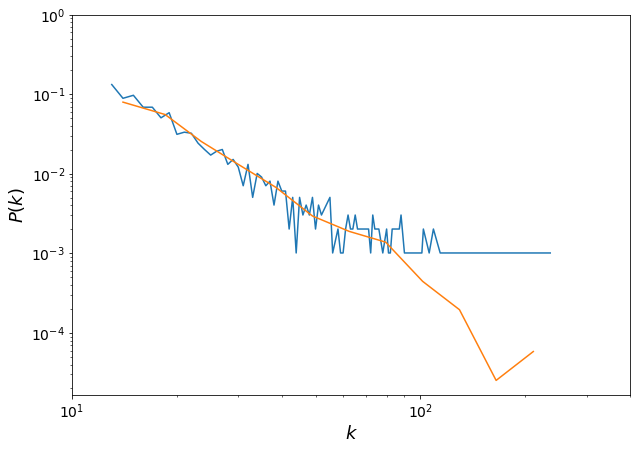

alpha =  2.4843055707717854
sigma =  0.04717432775799077
x_min =  11.0
Kolmogorov-Smirnov distance =  0.2196083020481211


In [29]:
# Create the degree distribution
AB_degree = dict(AB.degree()).values()
AB_degree_distribution = Counter(AB_degree)

# Plot the degree frequency distribution & 
# the probability density function 
plt.figure(figsize=(10,7))
x=[]
y=[]
for i in sorted(AB_degree_distribution):   
    x.append(i)
    y.append(float(AB_degree_distribution[i])/len(AB))

plt.plot(np.array(x),np.array(y))
pwl.plot_pdf(list(AB_degree))

plt.xlabel('$k$', fontsize=18)
plt.ylabel('$P(k)$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.axis([10,400,0.000,1])
plt.show()

# Fit the degree distribution with a power law
fit_function = pwl.Fit(list(AB_degree), xmin=11)

# Output parameters
print("alpha = ",fit_function.power_law.alpha)
print("sigma = ",fit_function.power_law.sigma)
print("x_min = ", fit_function.power_law.xmin)
print("Kolmogorov-Smirnov distance = ",fit_function.power_law.D)

#### G vs. WS
Watts stogatz netowrk combines small world (short average shortest path) with high clustering coefficient. This model starts from a reticule where each node is connected to its $d$ nearest neighbors,. and then with probability $r = 0.2$ each link is detached from one end and reformed with another random node.
Let's compare G with random **Watts-Strogatz** graph with the same average connectivity and number of nodes.<br>

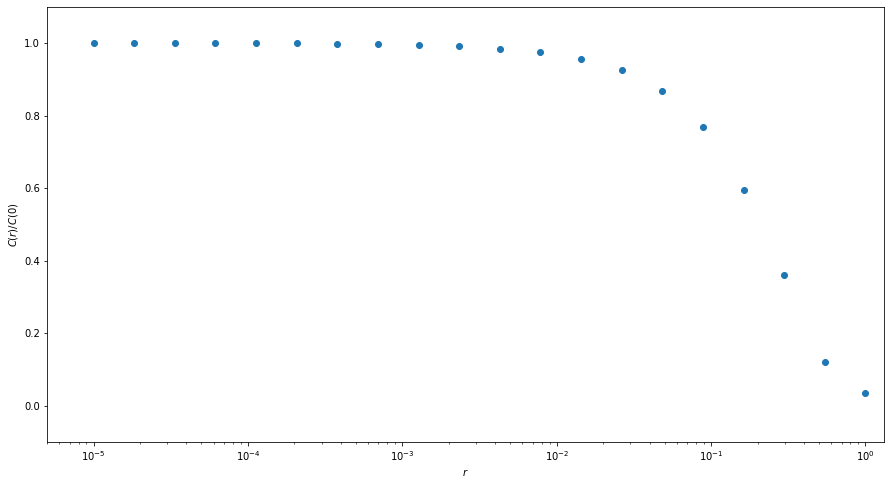

best rewiring rate =  0.2976351441631319 
best_avg_cc =  0.2603782426450593 ( 0.07470738709430241 apart from G's one)


In [30]:
#let's find the rewiring rate r that best approximates G, in terms of average clustering coefficient.
n = G.number_of_nodes()                              # nodal cardinality
d = 2*int(G.number_of_edges() / G.number_of_nodes())
avg_clust_coeffs_ws = []
r_log_list = numpy.logspace(-5, 0, num=20, endpoint=True, base=10.0, dtype=None, axis=0)
#print(r_list)
runs = 50
for r in r_log_list:
    WS = nx.connected_watts_strogatz_graph(n, d, r, runs)
    #WS = nx.watts_strogatz_graph(n, d, r)
    avg_clust_coeffs_ws.append(nx.average_clustering(WS))
   
avg_clust_coeffs_ws_norm = [avg_clust_coeffs_ws[i]/avg_clust_coeffs_ws[0] for i in range(len(avg_clust_coeffs_ws))]

plt.scatter(r_log_list,avg_clust_coeffs_ws_norm , marker = "o")
plt.xscale("log")
plt.xlabel("$r$")
plt.axis([0.000005,1.32,-0.1,1.1])
plt.ylabel("$C(r)/C(0)$")
plt.title("")
plt.show()

#find r value that best approximates G (in terms ofclustering coefficient; we couldn't choose the best compromise between average clustering coefficient and average shortest distance because the latter wouldhave taken too much time to evaluate for all r's)
best_avg_cc = avg_clust_coeffs_ws[np.argmin([abs(avg_clust_coeffs_ws[i]-G_avg_cc) for i in range(len(avg_clust_coeffs_ws))])]
best_r  = r_log_list[np.argmin([abs(avg_clust_coeffs_ws[i]-G_avg_cc) for i in range(len(avg_clust_coeffs_ws))])]

print("best rewiring rate = ",best_r, "\nbest_avg_cc = ",best_avg_cc ,"(",abs(best_avg_cc-G_avg_cc),"apart from G's one)")

In [31]:
# Input parameters
r = best_r

WS = nx.connected_watts_strogatz_graph(n, d, r, runs)

# Test connectedness
print("Is the WS graph simply connected ?", nx.is_connected(WS))

# Connectivity
print("The WS graph has", len(WS), "nodes", "and",len(WS.edges()),"edges .")

# Average clustering coefficient
print("The average clustering coefficient of WS is", nx.average_clustering(WS))

# Total number of triangles 
print("The total number of triangles in the network is", sum(list(nx.triangles(WS).values()))/3)

# Average shortest path
print("The WS graph has average shortest path  = ", nx.average_shortest_path_length(WS), 
     "\n.And we compare it with lnN/ln(<k>) = ", math.log(len(WS))/math.log(n*d/(n)))

Is the WS graph simply connected ? True
The WS graph has 990 nodes and 12870 edges .
The average clustering coefficient of WS is 0.266713549076812
The total number of triangles in the network is 28432.0
The WS graph has average shortest path  =  2.642324151525365 
.And we compare it with lnN/ln(<k>) =  2.1170965508951274


(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 <a list of 8 Text yticklabel objects>)

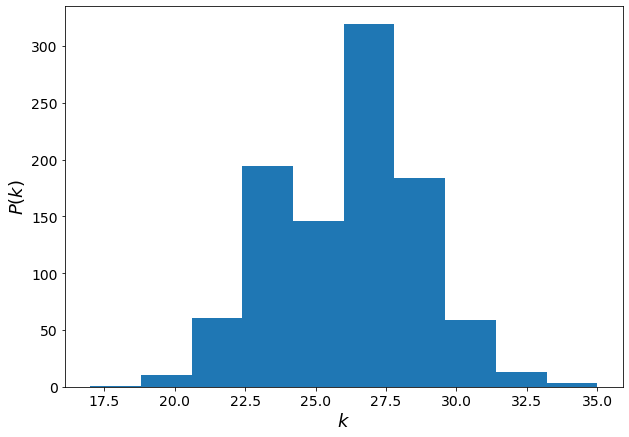

In [32]:
# Extract the degree distribution 
ws_degrees = (dict(WS.degree()).values())

# Plot the degree frequency distribution
plt.figure(figsize=(10,7))
plt.hist(ws_degrees, bins=10)
plt.xlabel('$k$', fontsize=18)
plt.ylabel('$P(k)$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Degree assortativity of a network

A network is assortative with respect to a feature/features if nodes with similar feature(s) values are more often connected between them rather then with nodes having different feature(s) values.<br>
The degree assortativity is assortativity with respect to degree: are nodes with similar degree more connected between themselves than with nodes with different degree?<br>
Degree assortativity can be measured in different ways. A simple approach is measuring the average nearest neighbor degree to assess the level of degree-assortativity.

In [33]:
# degree assortativity can also be computed with nx's functions
# Compute the degree assortativity coefficient of G and ER
dac_G = nx.degree_assortativity_coefficient(G) # this is the pearson correlation coefficient of the red dots of the plot above. Infact, for the ER network it is close to zero, since in a ER network nodes are likely to connect regardless of their degree.
dac_ER = nx.degree_assortativity_coefficient(ER)
dac_AB = nx.degree_assortativity_coefficient(AB)
dac_WS = nx.degree_assortativity_coefficient(WS)

print("The degree assortativity coefficient of G is", dac_G, 
      "\nwhile the degree assortativity coeffiecient of a ER graph is", dac_ER,
      "\nwhile the degree assortativity coeffiecient of a AB graph is" ,dac_AB,
      "\nwhile the degree assortativity coeffiecient of a WS graph is" ,dac_WS,)

# Compute the Pearson / linear correlation coefficient with nx function
pcc_G = nx.degree_pearson_correlation_coefficient(G)
pcc_ER = nx.degree_pearson_correlation_coefficient(ER)
pcc_AB = nx.degree_pearson_correlation_coefficient(AB)
pcc_WS = nx.degree_pearson_correlation_coefficient(WS)

print("The Pearson correlation coefficient of G is", pcc_G, 
      "\nwhile the Pearson correlation coeffiecient of a ER graph is", pcc_ER,
      "\nwhile the Pearson correlation coeffiecient of a AB graph is" ,pcc_AB,
      "\nwhile the Pearson correlation coeffiecient of a WS graph is" ,pcc_WS,)

The degree assortativity coefficient of G is -0.19241704798673884 
while the degree assortativity coeffiecient of a ER graph is -0.0074492109257502616 
while the degree assortativity coeffiecient of a AB graph is -0.024700267548471114 
while the degree assortativity coeffiecient of a WS graph is 0.007318607299651082
The Pearson correlation coefficient of G is -0.1924170479867377 
while the Pearson correlation coeffiecient of a ER graph is -0.00744921092575027 
while the Pearson correlation coeffiecient of a AB graph is -0.024700267548471776 
while the Pearson correlation coeffiecient of a WS graph is 0.007318607299647833


Anyway, thsi approachd oes not take into consideration possible nonlinear degree correlations.
A less powerful but more general approach would be to measure the average nearest neighbor degree per degree class, in order to determine a possible trend and to compar eit with the expected average nearest neighbor degree per degree class if the network is uncorrelated, in which case:

$$ k_{nn}^{unc}(k) = \frac{<k^2>}{<k>}$$

k_unc =  69.27780187997107


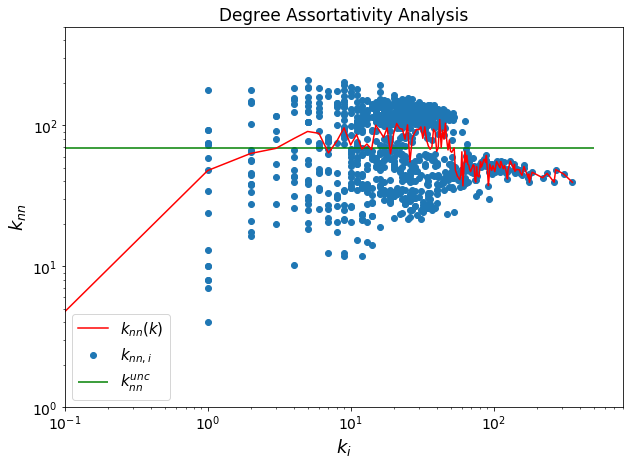

In [34]:
# Compute the average nearest neighbour degree for all the nodes in G 
x=[]
y=[]

avg_knn = defaultdict(list)

# so for every node n, extract its degree k and append to the value of the defaultdict avg_knn corresponding to the key k the average degree of the neighbours of that node. SO avg_knn becomes a dict of the type {k:[ak_1,ak_2,..]} where ak_i is the average degree of the neighbours of  the i-th node with degree k. Also save the k's in x and the average degrees of neighbours in y
for n in G.nodes():
    
    #k=soc.omit_by(dct = dict(G.degree()))
    k = G.degree(n)
    #nn=len(G.neighbors(n))
    total=0
    if k != 0:
        for j in G.neighbors(n):
            total += G.degree(j)

        avg_knn[k].append(float(total)/k)
        x.append(k)
        y.append(float(total)/k)
    else:
        avg_knn[k].append(0)
        x.append(k)
        y.append(0)
    



avg_knn_sort = {i:np.mean(avg_knn[i]) for i in sorted(avg_knn.keys())}
degree_distrib = {k:sum([1 if k == undirected_degree_distribution[i] else 0 for i in undirected_degree_distribution.keys()])/len(G) for k in np.unique(list(undirected_degree_distribution.values()))}
degrees = list(degree_distrib.keys())
probs = list(degree_distrib.values())
#k_unc = <k^2>/<k>
k_unc = sum([(degrees[k]**2)*probs[k] for k in range(len(degrees))])/sum([(degrees[k])*probs[k] for k in range(len(degrees))])
print("k_unc = ", k_unc)


# Plot scatter average nearest neighbour degree per node and average degree connectivity and expected uncorrelated average neighbour degree per degree class  vs. individual degree
knn_avg4_items = nx.average_degree_connectivity(G).items()
knn_avg4 = sorted(knn_avg4_items) # same as avg_knn_sort
#print(type(knn_avg4),knn_avg4[0])
z = [t[1] for t in knn_avg4]

plt.figure(figsize=(10,7))
plt.scatter(x,y, label='$k_{nn,i}$')
plt.hlines(k_unc, 0, 500, colors='green', linestyles='solid', label='$k^{unc}_{nn}$', data=None)
plt.plot(sorted(avg_knn.keys()), z,'r-', label='$k_{nn}(k)$')
#plt.plot(sorted(avg_knn.keys()), z1,'g-')
plt.legend(loc = 'lower left', fontsize = 15)
plt.xlabel('$k_i$', fontsize=18)
plt.ylabel('$k_{nn}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.title('Degree Assortativity Analysis', fontsize = 17)
# plt.axis([0.1,1000,1,1000])
plt.axis([0.1,800,1,500])
plt.show()



In [35]:
# rank_nodes = list of nodes to remove (one by one, progressively)
# returns a list of tuples ( number of removed nodes, size of gcc) where gcc is the giant connected component at that moment. The decay of the size of gcc is a measure of the robustness of the network, and/or ogf the efficiency of the attack. If importnat nodes are removed, size of gcc will dcrease rapidly, while if less important nodes aare removed, gcc size will decrease with the number of (less important) nodes removed.
def net_attack(graph, ranked_nodes):
    
    fraction_removed=[]#here we store the tuples: (%removed nodes, size of gcc)
    
    # make a copy of the graph to attack
    graph1=graph.copy()
    
    nnodes=len(ranked_nodes)
    n=0    
    
    gcc=sorted(list(nx.connected_components(graph1)),key=len, reverse=True)[0] 
    
    gcc_size=float(len(gcc))/nnodes
    print("gcc_size = ", gcc_size)
    fraction_removed.append( (float(n)/nnodes, gcc_size) )
    
    while gcc_size>0.01:
        
        #we start from the end of the list!
        graph1.remove_node(ranked_nodes.pop())

        gcc=sorted(list(nx.connected_components(graph1)),key=len, reverse=True)[0]
        gcc_size=float(len(gcc))/nnodes
        n+=1
        fraction_removed.append( (float(n)/nnodes, gcc_size) )
    
    return fraction_removed

In [36]:
# the attck sequence is the list of the airports in no particular order
nodes=list(G.nodes())
resilience_random=net_attack(G, nodes)

nodes_betw=[]

betw=nx.betweenness_centrality(G)
for i in sorted(betw.items(), key=itemgetter(1)):
    nodes_betw.append(i[0])

resilience_betw=net_attack(G, nodes_betw)

nodes_degree=[]

deg=dict(G.degree())
for i in sorted(deg.items(), key=itemgetter(1)):
    nodes_degree.append(i[0])

resilience_deg=net_attack(G, list(nodes_degree))

gcc_size =  0.9151515151515152
gcc_size =  0.9151515151515152
gcc_size =  0.9151515151515152


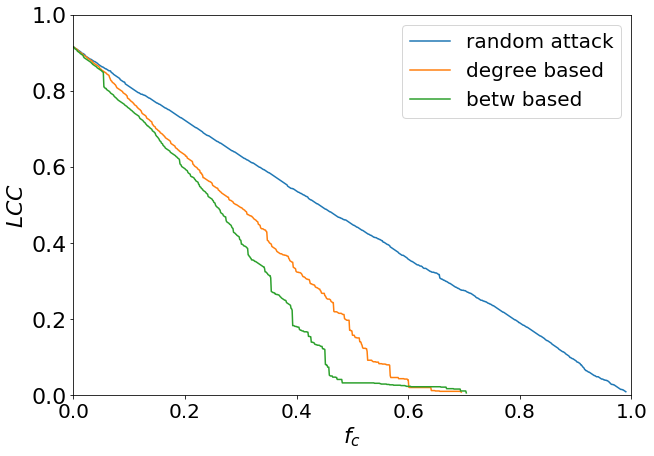

In [37]:
x=[k[0] for k in resilience_random]
y=[k[1] for k in resilience_random]

x1=[k[0] for k in resilience_deg]
y1=[k[1] for k in resilience_deg]

x2=[k[0] for k in resilience_betw]
y2=[k[1] for k in resilience_betw]

plt.figure(figsize=(10,7))

plt.plot(x,y, label='random attack')
plt.plot(x1,y1, label='degree based')
plt.plot(x2,y2, label='betw based')

plt.xlabel('$f_{c}$', fontsize=22)
plt.ylabel('$LCC$', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=22)
plt.axis([0,1,0,1])

plt.legend(loc='upper right', fontsize=20)
# y-axis is the size of the largest connected component, normalized wit hthe initial gcc's size. x-axis is treh fraction of nodses removed. note that degree or betweennes-based attacks are more effective than random attack. thus a network with a broad p_k is very weak against degree/betweeness attacks

## Stochastic SIR Epidemic on Static Network

In [ ]:
# Model Parameters
mu = 0.2           # Recovery rate 
lambd = 0.01       # Transmission rate per contact

# Simulation Parameters
nrun = 700       # Number of runs

# Multi-Run Simulation
runs = soc.network_SIR_multirun_simulation(G, nrun = nrun, lambd = lambd, mu = mu)

# Set figure size 
plt.figure(figsize=(10,7))

# Plot the ensemble of trajectories
soc.plot_ensemble(runs)

### $\lambda$-Sensitivity of Final Epidemic Size

In [ ]:
# Perform lambda-sensitivity analysis of final epidemic size (normalized attack rate) 
data = soc.network_SIR_finalsize_lambda_sensitivity(G, mu = mu, rho = 0.05, # rho = initial fraction infected
                                                    lambda_min = 0.0001, lambda_max = 1.0, 
                                                    nruns = 20)
# Show sensitivity dataset
data 

# Set figure size 
plt.figure(figsize=(10,7))

# Display a boxplot with final epidemic size vs. transmission rate per edge/contact
soc.boxplot_finalsize_lambda_sensitivity(G, mu = mu, data = data, 
                                         ymin = 0.045, ymax= 1.1,
                                         xlim = (0.00007, 1.5) )